# Treinamento de modelo próprio para reconhecimento de texto manuscrito



In [366]:
try:
    import google.colab
    IN_COLAB = True
    print("Executando no Google Colab")
except ImportError:
    IN_COLAB = False
    print("Não executando no Google Colab")

Não executando no Google Colab


In [367]:
if IN_COLAB:
    # Baixar imagens para o laboratório.
    !wget https://github.com/fabiobento/ocr-sis-emb-2024-2/raw/refs/heads/main/imagens.zip
    !unzip -n -q imagens.zip

# Importando as bibliotecas

In [368]:
import tensorflow
tensorflow.__version__

'2.17.0'

In [369]:
import numpy as np
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
if IN_COLAB:
    from google.colab.patches import cv2_imshow

In [370]:
# Definir função para exibição de imagens
def imshow(imagem):
    if IN_COLAB:
        cv2_imshow(imagem)
    else:
        # Exibir a imagem com matplotlib
        if len(imagem.shape) == 2:  # Se a imagem tiver apenas 2 dimensões (níveis de cinza)
            plt.imshow(imagem, cmap='gray')
            plt.axis('off')  # Oculta os eixos
            plt.show()               
        else:
            plt.imshow(imagem)        
            plt.axis('off')  # Oculta os eixos
            plt.show()   

# Carregando as bases de dados

## Conjunto MNIST 0-9

In [371]:
from tensorflow.keras.datasets import mnist

In [372]:
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

In [373]:
train_data.shape, test_data.shape

((60000, 28, 28), (10000, 28, 28))

In [374]:
28 * 28

784

In [375]:
train_labels.shape, test_labels.shape

((60000,), (10000,))

In [376]:
train_data[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [377]:
train_data[0].shape

(28, 28)

In [378]:
train_labels[0]

5

In [379]:
digitos_data = np.vstack([train_data, test_data])
digitos_labels = np.hstack([train_labels, test_labels])

In [380]:
digitos_data.shape

(70000, 28, 28)

In [381]:
digitos_labels.shape

(70000,)

In [382]:
digitos_labels

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

In [383]:
np.random.randint(0, digitos_data.shape[0])

46966

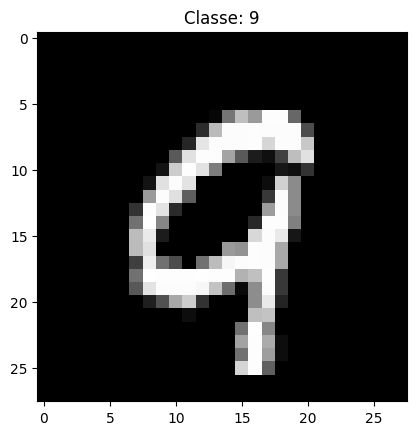

In [384]:
indice = np.random.randint(0, digitos_data.shape[0])
plt.imshow(digitos_data[indice], cmap='gray')
plt.title('Classe: ' + str(digitos_labels[indice]));

<Axes: ylabel='count'>

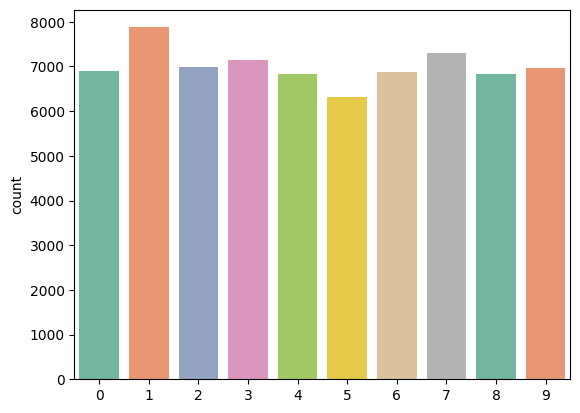

In [385]:
sns.countplot(x=digitos_labels,hue=digitos_labels, palette="Set2", legend=False)

## Conjunto Kaggle A-Z

In [386]:
if IN_COLAB:
  # Baixar imagens do conjunto de dados
  %pip install gdown
  !gdown --id 1udg4POqbFlozb9OemBNYKw4prQ4Dmh9s -O alfabeto_A-Z.zip
  !unzip -n -q alfabeto_A-Z.zip

In [387]:
dataset_az = pd.read_csv('./Datasets/A_Z Handwritten Data.csv').astype('float32')

In [388]:
#dataset_az

In [389]:
alfabeto_data = dataset_az.drop('0', axis = 1)
alfabeto_labels = dataset_az['0']

In [390]:
alfabeto_data.shape, alfabeto_labels.shape

((372450, 784), (372450,))

In [391]:
#alfabeto_labels

In [392]:
alfabeto_data = np.reshape(alfabeto_data.values, (alfabeto_data.shape[0], 28, 28))

In [393]:
alfabeto_data.shape

(372450, 28, 28)

Text(0.5, 1.0, 'Classe 14.0')

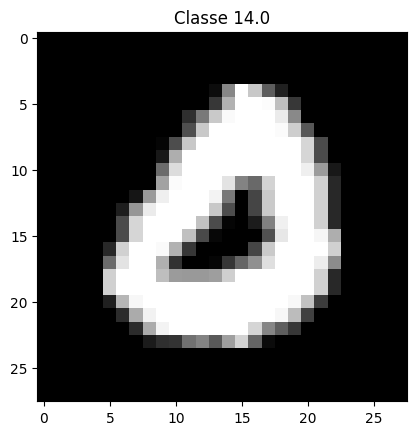

In [394]:
indice = np.random.randint(0, alfabeto_data.shape[0])
plt.imshow(alfabeto_data[indice], cmap = 'gray')
plt.title('Classe ' + str(alfabeto_labels[indice]))

<Axes: xlabel='0', ylabel='count'>

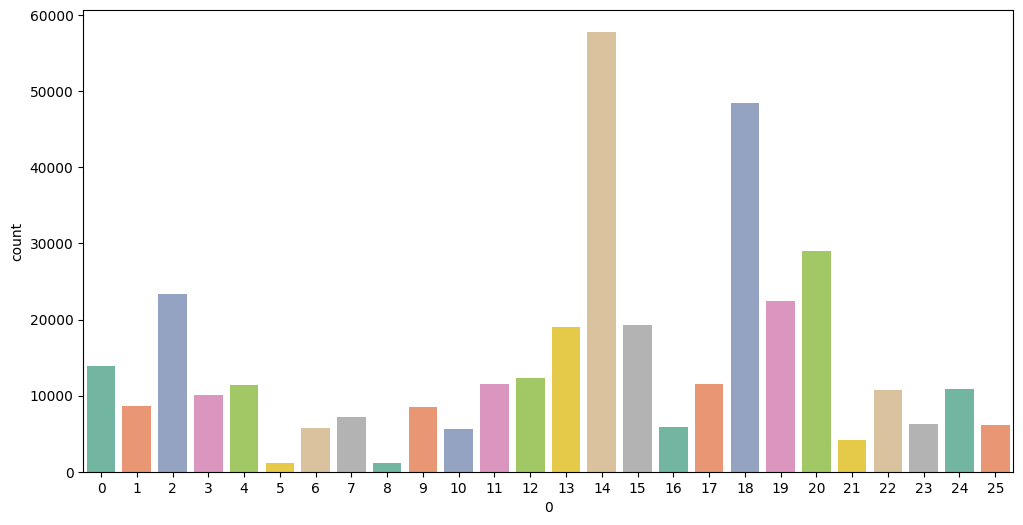

In [395]:
alfabeto_labels_int = alfabeto_labels.astype(int)
plt.figure(figsize=(12, 6))
sns.countplot(x=alfabeto_labels_int,hue=alfabeto_labels_int, palette="Set2", legend=False)

## Junção das bases de dados

In [396]:
digitos_labels, np.unique(digitos_labels)

(array([5, 0, 4, ..., 4, 5, 6], dtype=uint8),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [397]:
alfabeto_labels, np.unique(alfabeto_labels)

(0          0.0
 1          0.0
 2          0.0
 3          0.0
 4          0.0
           ... 
 372445    25.0
 372446    25.0
 372447    25.0
 372448    25.0
 372449    25.0
 Name: 0, Length: 372450, dtype: float32,
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.],
       dtype=float32))

In [398]:
alfabeto_labels += 10

In [399]:
alfabeto_labels, np.unique(alfabeto_labels)

(0         10.0
 1         10.0
 2         10.0
 3         10.0
 4         10.0
           ... 
 372445    35.0
 372446    35.0
 372447    35.0
 372448    35.0
 372449    35.0
 Name: 0, Length: 372450, dtype: float32,
 array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22.,
        23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.],
       dtype=float32))

In [400]:
data = np.vstack([alfabeto_data, digitos_data])
labels = np.hstack([alfabeto_labels, digitos_labels])

In [401]:
data.shape, labels.shape

((442450, 28, 28), (442450,))

In [402]:
data = np.array(data, dtype='float32')

In [403]:
data.shape

(442450, 28, 28)

In [404]:
data = np.expand_dims(data, axis = -1)

In [405]:
data.shape

(442450, 28, 28, 1)

# Pré-processamento dos dados

In [406]:
data[0].min(), data[0].max()

(0.0, 255.0)

In [407]:
data /= 255.0

In [408]:
data[0].min(), data[0].max()

(0.0, 1.0)

In [409]:
np.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35.], dtype=float32)

In [410]:
le = LabelBinarizer()
labels = le.fit_transform(labels)

In [411]:
np.unique(labels)

array([0, 1])

In [412]:
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [413]:
labels[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [414]:
labels[30000], len(labels[30000]), 26 + 10

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 36,
 36)

In [415]:
# OneHotEncoder
# A, B, C, Z
# 0, 1, 2, 25

# A, B, C
# 1, 0, 0
# 0, 1, 0
# 0, 0, 1

In [416]:
classes_total = labels.sum(axis=0)
classes_total

array([ 6903,  7877,  6990,  7141,  6824,  6313,  6876,  7293,  6825,
        6958, 13869,  8668, 23409, 10134, 11440,  1163,  5762,  7218,
        1120,  8493,  5603, 11586, 12336, 19010, 57825, 19341,  5812,
       11566, 48419, 22495, 29008,  4182, 10784,  6272, 10859,  6076])

In [417]:
classes_total.max()

57825

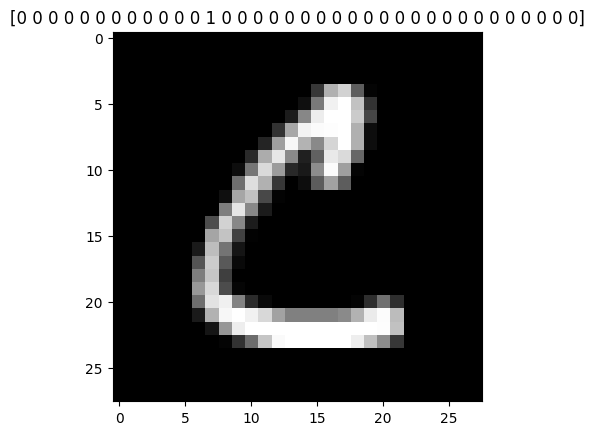

In [418]:
plt.imshow(data[30000].reshape(28,28), cmap='gray')
plt.title(str(labels[30000]));

In [419]:
classes_peso = {}
for i in range(0, len(classes_total)):
  #print(i)
  classes_peso[i] = classes_total.max() / classes_total[i]

In [420]:
classes_peso

{0: 8.376792698826597,
 1: 7.340992763742541,
 2: 8.272532188841202,
 3: 8.097605377398123,
 4: 8.473769050410317,
 5: 9.15967052114684,
 6: 8.409685863874346,
 7: 7.928835870012341,
 8: 8.472527472527473,
 9: 8.310577752227651,
 10: 4.169370538611291,
 11: 6.671089063221043,
 12: 2.4702037677816224,
 13: 5.7060390763765545,
 14: 5.0546328671328675,
 15: 49.72055030094583,
 16: 10.035577924331829,
 17: 8.011221945137157,
 18: 51.629464285714285,
 19: 6.808548216178029,
 20: 10.320364090665715,
 21: 4.990937338166753,
 22: 4.6875,
 23: 3.0418200946870066,
 24: 1.0,
 25: 2.989762680316426,
 26: 9.94924294562973,
 27: 4.999567698426422,
 28: 1.1942625828703608,
 29: 2.5705712380529007,
 30: 1.993415609487038,
 31: 13.827116212338593,
 32: 5.362110534124629,
 33: 9.21954719387755,
 34: 5.3250759738465785,
 35: 9.51695194206715}

In [421]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state = 1)

In [422]:
X_train.shape, X_test.shape

((353960, 28, 28, 1), (88490, 28, 28, 1))

In [423]:
y_train.shape, y_test.shape

((353960, 36), (88490, 36))

In [424]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [425]:
augmentation = ImageDataGenerator(rotation_range=10, zoom_range=0.05, width_shift_range=0.1,
                                  height_shift_range=0.1, horizontal_flip = False)

# Criação da estrutura da rede neural

- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

In [426]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

In [427]:
rede_neural = Sequential()

rede_neural.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)))
rede_neural.add(MaxPool2D(pool_size=(2,2)))

rede_neural.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
rede_neural.add(MaxPool2D(pool_size=(2,2)))

rede_neural.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='valid'))
rede_neural.add(MaxPool2D(pool_size=(2,2)))

rede_neural.add(Flatten())

rede_neural.add(Dense(64, activation='relu'))
rede_neural.add(Dense(128, activation='relu'))

rede_neural.add(Dense(36, activation='softmax'))

rede_neural.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [428]:
2 * 2 * 128

512

In [429]:
rede_neural.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,468 (540.89 KB)

 Trainable params: 138,468 (540.89 KB)

 Non-trainable params: 0 (0.00 B)

In [430]:
nomes_labels = '0123456789'
nomes_labels += 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
nomes_labels = [l for l in nomes_labels]

In [431]:
print(nomes_labels)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


# Treinamento da rede neural

In [432]:
arquivo_modelo = 'manuscrito.model'
epochs = 20
batch_size = 128

In [433]:
checkpointer = ModelCheckpoint(arquivo_modelo + '.keras', monitor='val_loss', verbose=1, save_best_only=True) 

In [434]:
len(X_train) // batch_size

2765

In [435]:
# Perguntar ao usuário
opcao = input("Deseja treinar o modelo do zero ou carregar um modelo pré-treinado? (treinar/carregar): ").lower()

if opcao == 'treinar':
    # Treinar o modelo do zero
    history = rede_neural.fit(
        augmentation.flow(X_train, y_train, batch_size=batch_size),
        validation_data=(X_test, y_test),
        steps_per_epoch=len(X_train) // batch_size,
        epochs=epochs,
        class_weight=classes_peso,
        verbose=1,
        callbacks=[checkpointer]
    )
    print("Modelo treinado com sucesso!")

elif opcao == 'carregar':
    if IN_COLAB:
        # Instalar gdown no Colab se necessário
        %pip install gdown
        import gdown
        # Baixar o arquivo do modelo
        print("Baixando o modelo pré-treinado...")
        gdown.download('https://drive.google.com/uc?id=1-8PIRKmba7_p1DGDIvzWCcPZiT-4g6C-', 'rede_neural.keras', quiet=False)
    else:
      !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1-8PIRKmba7_p1DGDIvzWCcPZiT-4g6C-' -O rede_neural.keras   
    # Carregar o modelo pré-treinado
    rede_neural = load_model('rede_neural.keras')
    print("Modelo pré-treinado carregado com sucesso!")

else:
    print("Opção inválida. Por favor, escolha 'treinar' ou 'carregar'.")


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2759/2765 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7066 - loss: 4.2720
Epoch 1: val_loss improved from inf to 0.34484, saving model to manuscrito.model.keras
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - accuracy: 0.7069 - loss: 4.2669 - val_accuracy: 0.8662 - val_loss: 0.3448
Epoch 2/20
   1/2765 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8359 - loss: 1.0447

/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.34484 to 0.33654, saving model to manuscrito.model.keras
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 2s 607us/step - accuracy: 0.8359 - loss: 1.0447 - val_accuracy: 0.8670 - val_loss: 0.3365
Epoch 3/20
2763/2765 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8951 - loss: 1.0551
Epoch 3: val_loss improved from 0.33654 to 0.27620, saving model to manuscrito.model.keras
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - accuracy: 0.8951 - loss: 1.0551 - val_accuracy: 0.8800 - val_loss: 0.2762
Epoch 4/20
   1/2765 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8672 - loss: 1.2655
Epoch 4: val_loss improved from 0.27620 to 0.27595, saving model to manuscrito.model.keras
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 2s 609us/step - accuracy: 0.8672 - loss: 1.2655 - val_accuracy: 0.8788 - val_loss: 0.2759
Epoch 5/20
2759/2765 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9115 - loss: 0.8324
Epoch 5: val_loss improved from 0.27595 to 0.22913, saving model to manuscrito.model.keras
2765/2

2024-09-28 15:38:30.372658: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5765903383460205332
2024-09-28 15:38:30.372686: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3802046507611069636
2024-09-28 15:38:30.372694: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16060791353091858208



Epoch 8: val_loss did not improve from 0.21973
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 2s 685us/step - accuracy: 0.8906 - loss: 0.5464 - val_accuracy: 0.8769 - val_loss: 0.2954
Epoch 9/20
2757/2765 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9253 - loss: 0.6786
Epoch 9: val_loss did not improve from 0.21973
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - accuracy: 0.9253 - loss: 0.6786 - val_accuracy: 0.9073 - val_loss: 0.2231
Epoch 10/20
   1/2765 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9453 - loss: 0.5723

2024-09-28 15:39:08.823771: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5765903383460205332
2024-09-28 15:39:08.823795: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16060791353091858208



Epoch 10: val_loss did not improve from 0.21973
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 2s 669us/step - accuracy: 0.9453 - loss: 0.5723 - val_accuracy: 0.9053 - val_loss: 0.2281
Epoch 11/20
2759/2765 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9297 - loss: 0.6303
Epoch 11: val_loss improved from 0.21973 to 0.19116, saving model to manuscrito.model.keras
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - accuracy: 0.9297 - loss: 0.6303 - val_accuracy: 0.9218 - val_loss: 0.1912
Epoch 12/20
   1/2765 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9141 - loss: 0.9566

2024-09-28 15:39:46.695077: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 12: val_loss improved from 0.19116 to 0.18785, saving model to manuscrito.model.keras
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 2s 632us/step - accuracy: 0.9141 - loss: 0.9566 - val_accuracy: 0.9233 - val_loss: 0.1879
Epoch 13/20
2760/2765 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9328 - loss: 0.5959
Epoch 13: val_loss did not improve from 0.18785
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - accuracy: 0.9328 - loss: 0.5959 - val_accuracy: 0.9220 - val_loss: 0.1975
Epoch 14/20
   1/2765 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9766 - loss: 0.2456

2024-09-28 15:40:24.445415: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5765903383460205332
2024-09-28 15:40:24.445434: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3802046507611069636
2024-09-28 15:40:24.445442: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16060791353091858208



Epoch 14: val_loss did not improve from 0.18785
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 2s 705us/step - accuracy: 0.9766 - loss: 0.2456 - val_accuracy: 0.9203 - val_loss: 0.2005
Epoch 15/20
2760/2765 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9359 - loss: 0.5481
Epoch 15: val_loss did not improve from 0.18785
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - accuracy: 0.9359 - loss: 0.5481 - val_accuracy: 0.8840 - val_loss: 0.2704
Epoch 16/20
   1/2765 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8828 - loss: 0.6390

2024-09-28 15:41:02.483551: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5765903383460205332
2024-09-28 15:41:02.483582: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3802046507611069636
2024-09-28 15:41:02.483596: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16060791353091858208



Epoch 16: val_loss did not improve from 0.18785
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 2s 602us/step - accuracy: 0.8828 - loss: 0.6390 - val_accuracy: 0.8820 - val_loss: 0.2756
Epoch 17/20
2764/2765 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9365 - loss: 0.5419
Epoch 17: val_loss did not improve from 0.18785
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - accuracy: 0.9365 - loss: 0.5419 - val_accuracy: 0.8646 - val_loss: 0.3116
Epoch 18/20
   1/2765 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9766 - loss: 0.1873

2024-09-28 15:41:40.205373: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5765903383460205332



Epoch 18: val_loss did not improve from 0.18785
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 2s 557us/step - accuracy: 0.9766 - loss: 0.1873 - val_accuracy: 0.8599 - val_loss: 0.3230
Epoch 19/20
2760/2765 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9390 - loss: 0.5065
Epoch 19: val_loss did not improve from 0.18785
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - accuracy: 0.9390 - loss: 0.5065 - val_accuracy: 0.8795 - val_loss: 0.2766
Epoch 20/20
   1/2765 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9609 - loss: 0.3368

2024-09-28 15:42:16.998048: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5765903383460205332
2024-09-28 15:42:16.998078: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3802046507611069636
2024-09-28 15:42:16.998095: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16060791353091858208



Epoch 20: val_loss did not improve from 0.18785
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 2s 573us/step - accuracy: 0.9609 - loss: 0.3368 - val_accuracy: 0.8767 - val_loss: 0.2827
Modelo treinado com sucesso!


# Avaliação da rede neural

In [436]:
X_test.shape

(88490, 28, 28, 1)

In [437]:
previsoes = rede_neural.predict(X_test, batch_size=batch_size)

692/692 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step


In [438]:
previsoes

array([[4.0273055e-01, 1.2088600e-07, 3.2093226e-07, ..., 1.3137763e-11,
        4.1405804e-07, 2.0279190e-08],
       [1.8824786e-18, 8.4285716e-08, 3.3608252e-11, ..., 1.0870812e-10,
        3.0490530e-12, 3.9961275e-08],
       [6.0611766e-10, 8.9911828e-10, 3.3249122e-11, ..., 9.3091588e-09,
        7.0233874e-08, 5.6213757e-15],
       ...,
       [9.1588837e-01, 5.3130629e-09, 2.0124380e-09, ..., 2.0197901e-17,
        1.9159503e-09, 2.8720496e-12],
       [7.0251079e-19, 1.5193733e-11, 9.0526503e-11, ..., 9.9998391e-01,
        5.5602222e-06, 1.1216703e-09],
       [1.5972540e-09, 6.4621228e-14, 2.0719965e-10, ..., 2.4999945e-15,
        1.0795972e-11, 1.9643338e-09]], dtype=float32)

In [439]:
previsoes[0]

array([4.0273055e-01, 1.2088600e-07, 3.2093226e-07, 2.9354810e-09,
       1.3401612e-07, 1.2509576e-08, 9.7763977e-06, 7.1667266e-08,
       4.2410352e-07, 2.4032636e-07, 4.7040180e-06, 2.1740530e-06,
       9.8320437e-05, 1.0780433e-02, 4.9862598e-07, 9.5971098e-10,
       1.9282472e-06, 2.3834325e-08, 3.4097734e-09, 4.7337653e-06,
       1.4598907e-10, 1.5142935e-07, 1.0083752e-07, 5.1191428e-06,
       5.8504313e-01, 2.3826292e-04, 1.0362134e-03, 3.9032562e-07,
       8.8127319e-07, 4.8162894e-07, 4.0253351e-05, 8.0719642e-10,
       8.2848963e-08, 1.3137763e-11, 4.1405804e-07, 2.0279190e-08],
      dtype=float32)

In [440]:
len(previsoes[0])

36

In [441]:
np.argmax(previsoes[0])

24

In [442]:
nomes_labels[24]

'O'

In [443]:
y_test[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [444]:
np.argmax(y_test[0])

24

In [445]:
nomes_labels[np.argmax(y_test[0])]

'O'

In [446]:
rede_neural.evaluate(X_test, y_test)

2766/2766 ━━━━━━━━━━━━━━━━━━━━ 2s 662us/step - accuracy: 0.8771 - loss: 0.2804


[0.2826797068119049, 0.8767431378364563]

In [447]:
print(classification_report(y_test.argmax(axis=1), previsoes.argmax(axis=1), target_names=nomes_labels))

              precision    recall  f1-score   support

           0       0.17      0.97      0.28      1381
           1       0.95      1.00      0.97      1575
           2       0.90      0.98      0.94      1398
           3       0.97      0.99      0.98      1428
           4       0.89      0.98      0.93      1365
           5       0.36      0.98      0.52      1263
           6       0.93      0.97      0.95      1375
           7       0.95      0.99      0.97      1459
           8       0.97      0.98      0.98      1365
           9       0.95      0.98      0.97      1392
           A       0.99      0.99      0.99      2774
           B       0.98      0.98      0.98      1734
           C       0.99      0.97      0.98      4682
           D       0.86      0.97      0.91      2027
           E       0.99      0.98      0.98      2288
           F       0.95      1.00      0.97       233
           G       0.93      0.96      0.94      1152
           H       0.97    

In [448]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

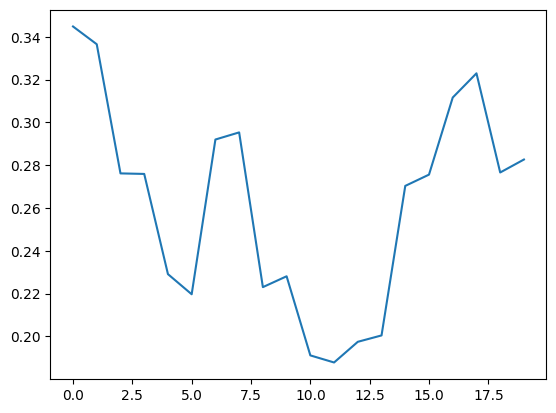

In [449]:
plt.plot(history.history['val_loss']);

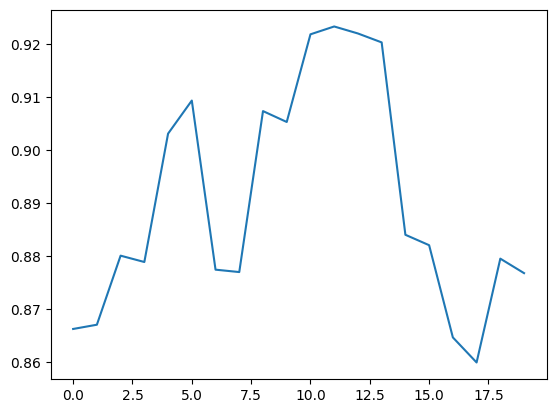

In [450]:
plt.plot(history.history['val_accuracy']);

# Salvando o modelo

In [451]:
rede_neural.save('rede_neural.keras')    
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    !mkdir -p /content/drive/MyDrive/sistemas_embarcados
    !cp rede_neural.keras /content/drive/MyDrive/sistemas_embarcados/rede_neural.keras

# Teste com imagens

In [452]:
from tensorflow.keras.models import load_model

In [453]:
rede_neural_carregada = load_model('rede_neural.keras')

In [454]:
rede_neural_carregada

<Sequential name=sequential_3, built=True>

In [455]:
rede_neural_carregada.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 415,406 (1.58 MB)

 Trainable params: 138,468 (540.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 276,938 (1.06 MB)

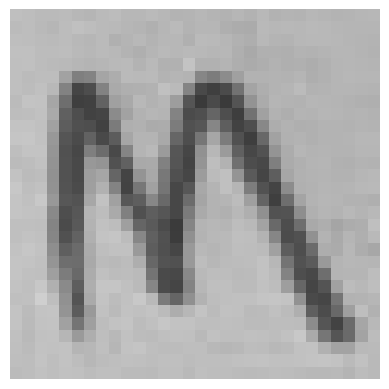

In [456]:
img = cv2.imread('./Imagens/letra-m.jpg')
imshow(img)

In [457]:
img.shape

(30, 30, 3)

In [458]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(30, 30)

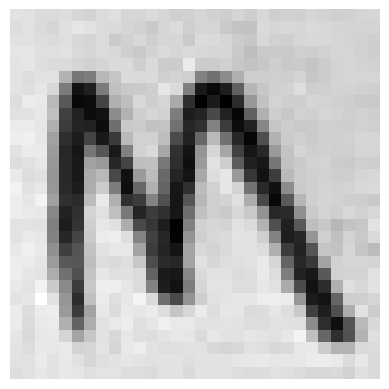

In [459]:
imshow(gray)

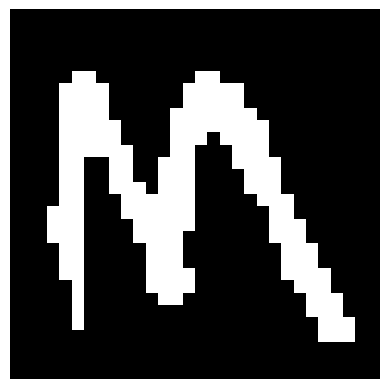

In [460]:
val, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
imshow(thresh)

In [461]:
val

137.0

In [462]:
thresh.shape

(30, 30)

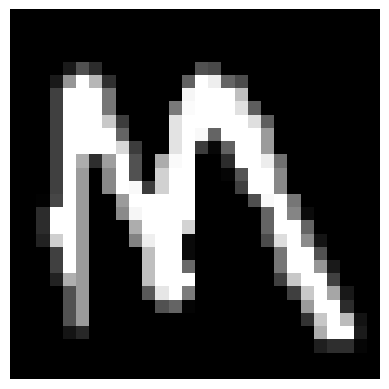

In [463]:
img = cv2.resize(thresh, (28, 28))
imshow(img)

In [464]:
img.shape

(28, 28)

In [465]:
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis = -1)
img.shape

(28, 28, 1)

In [466]:
img = np.reshape(img, (1,28,28,1))
img.shape

(1, 28, 28, 1)

In [467]:
previsao = rede_neural_carregada.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


In [468]:
previsao

array([[1.4568630e-03, 7.4080919e-05, 2.0965746e-05, 1.1681437e-06,
        1.5195779e-04, 4.5605841e-08, 3.7611890e-06, 1.2325213e-04,
        5.8152909e-06, 6.8428670e-04, 2.3694990e-02, 1.6766136e-05,
        1.9204970e-05, 8.3282121e-02, 2.6320761e-06, 3.6110039e-11,
        1.3702227e-04, 2.3058307e-04, 8.7748706e-09, 7.6587838e-07,
        9.5834694e-06, 2.7286485e-06, 8.7459153e-01, 1.0554764e-02,
        1.6850267e-03, 1.4564289e-06, 1.4391151e-04, 1.2929316e-03,
        1.4987273e-05, 7.6487930e-05, 1.6533693e-03, 2.8205213e-10,
        5.2186999e-05, 8.0405101e-07, 9.6141812e-06, 4.3840096e-06]],
      dtype=float32)

In [469]:
np.argmax(previsao)

22

In [470]:
nomes_labels[22]

'M'